## PCGML Level Generation using Tile Embeddings

In this notebook, we will walk you through the step-by-step level generation for the game Bubble Bobble. 

### BIRD'S EYE VIEW: 
1. We first discuss the pre-requisties in terms of data generation.
2. Data loading and preparation
3. Model definition and training
4. Level generation and visualisation

#### 1. Pre-requisties:
1. Convert the dataset levels to embedded level representation. For converting the Bubble Bobble levels, execute the code rep_no_affordances.py in the terminal. This will transform and save the levels in the directory data/unified_rep/Bubble_Bobble as shown in the figure

<img src="images/level_representation.png">

Let's start by importing a whole bunch of python libraries that we will need for the implementation.

In [14]:
#importing libraries
import pandas as pd
import numpy as np
import pickle
import keras.backend as K
from keras.layers import (
    Dense,
    Conv2D,
    Activation,
    Dropout,
    Input,
    MaxPooling2D,
    Flatten,
    BatchNormalization,
    LeakyReLU,
    Embedding,
    LSTM,
    Add,
)
from keras.models import Model
from keras import optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.preprocessing import sequence, image
from keras.preprocessing.image import load_img, save_img
from keras.preprocessing.image import array_to_img, img_to_array
from keras import callbacks
from keras import regularizers
import glob
from collections import Counter
from PIL import Image, ImageOps
from annoy import AnnoyIndex

In [15]:
!pip3 install pickle5

In [16]:
import pickle5 as pickle

### 1. Load encoder-decoder model and embedded level representations 

In [17]:
# load the multilabel binarizer
# Dosent get used as far as I know
with open("../model/model_tokenizer.pickle", "rb") as handle:
    mlb = pickle.load(handle)
print("Feature Dictionary Loaded")
total_features = len(mlb.classes_)
print("The feature dictionary has size", total_features)
display("Features", mlb.classes_)

# load entire autoencoder architecture
json_file = open("../model/autoencoder_model_test.json", "r")
loaded_model_json = json_file.read()
json_file.close()
ae_sep_output = model_from_json(loaded_model_json)
ae_sep_output.load_weights("../model/autoencoder_model_test.h5")
print("Loaded Entire Autoencoder Model from the Disk")

# load the encoding architecture and weights
json_file = open("../model/encoder_model_test.json", "r")
loaded_model_json = json_file.read()
json_file.close()
encoding_model = model_from_json(loaded_model_json)
encoding_model.load_weights("../model/encoder_model_test.h5")
print("Loaded Encoder Model from the Disk")

# load the decoding architecture and weights
json_file = open("../model/decoder_model_test.json", "r")
loaded_model_json = json_file.read()
json_file.close()
decoding_model = model_from_json(loaded_model_json)
# load weights into new model
decoding_model.load_weights("../model/decoder_model_test.h5")
print("Loaded Decoder Model from the Disk")

Feature Dictionary Loaded
The feature dictionary has size 13


'Features'

array(['block', 'breakable', 'climbable', 'collectable', 'element',
       'empty', 'hazard', 'moving', 'openable', 'passable', 'pipe',
       'solid', 'wall'], dtype=object)

Loaded Entire Autoencoder Model from the Disk
Loaded Encoder Model from the Disk
Loaded Decoder Model from the Disk


### 2.1 Data Loading 

In [18]:
# load the embedded level representations
save_dir="../data/unified_rep/bubble_bobble/"
embedding_paths=glob.glob(save_dir+"*.pickle")
print("\nTotal Number of paths read : ",len(embedding_paths))
print("Printing Sample paths ",embedding_paths[:5])


Total Number of paths read :  95
Printing Sample paths  ['../data/unified_rep/bubble_bobble/round45.pickle', '../data/unified_rep/bubble_bobble/round99.pickle', '../data/unified_rep/bubble_bobble/round17.pickle', '../data/unified_rep/bubble_bobble/round37.pickle', '../data/unified_rep/bubble_bobble/round16.pickle']


In [19]:
def get_pickle(pickle_path):
    '''
    This function loads the pickle file
    
    Input
    pickle_path: path of the pickle file
    Output
    Loads and returns the stored pickle file
    
    '''
    with open(pickle_path, "rb") as handle:
        level_pickle = pickle.load(handle)
    return level_pickle

### 2.2 Data Preparation

In this step we build the training batches for model training. A high level architecture of our LSTM generator can be visualised as:

<div>
<img src="images/lstm_training.png", width=80%>
 </div>
 
#### Highlights of the architecture:
We adapt the work by [Summerville and Mateas](https://arxiv.org/pdf/1603.00930) for this implementation.
1. The input to the LSTM is a (156 * 256) representation of a level. This representation is obtained by transforming (16* 16) pixel tiles of (192 * 208) pixel level image to a (12 * 13 * 256) embedding representation. Further this representation is unrolled column-wise to obtain a final representation of dimension (156 * 256). 
2. Column Array - For a (156 * 256) embedding representation, we generate a corresponding column weight array of size (156,). The column character is incremented after every three columns.
3. EOS and SOS are *start of sequence* and *end of sequence* tokens respectively.
4. *N* is number of history tiles considered in the implementation. We consider last 6 i.e. 78 tiles.
5. Given the history of last 6 columns, we generate next 6 columns. This is denoted by paramter *next_N* 

In [20]:
#generate a column array
col=0
level_col=[]
for i in range(13):
    if i%3==0:
        col+=1
    for j in range(12):
        level_col.append(col)
level_col=np.array(level_col)

print(level_col)
print(level_col.shape)

# define start and end token for the sequence
sos_array=[9] * 256
sos_array=np.array(sos_array).reshape(1,256)
eos_array=[5] * 256
eos_array=np.array(eos_array).reshape(1,256)

#building training batches
N=78
#next_N=78
next_N = 78
training_input_batch=[]
training_target_batch=[]
training_column_batch=[]
trainingColumnBatch = []

#for i, embed_path in enumerate(embedding_paths):
for i, embed_path in enumerate(embedding_paths[:3]):
    
    level_identifier=embed_path.split("/")[-1].split('.')[0]
    level_embedding=get_pickle(embed_path)
    print(f"Level Embedding Shape {i}: {level_embedding.shape}")
    level_column=level_col

    for idx in range(len(level_embedding)-next_N):
        print(f"IDX: {idx}")
        if idx>N:
            low_bound=idx-N
            print(f"Low Bound: {low_bound}")
            data_i=level_embedding[low_bound:idx]
            data_t=level_embedding[idx:idx+next_N]
            data_c=level_column[low_bound:idx]
            assert data_i.shape==(N,256)
            assert data_t.shape==(next_N,256)
        else:
            pad_length=N-idx
            print(f"Pad Length: {pad_length}")
            pad_array=np.zeros((pad_length,256))
            # Data i is embeddings padded for first 78 tiles. (xTrain)
            data_i=np.concatenate((pad_array,level_embedding[:idx]),axis=0)
            print(data_i[0])
            # Data t is the target for data i above. The next 78 tiles in the sequnce (yTruth)
            data_t=level_embedding[idx:idx+next_N]
            
            pad_array1=np.zeros((pad_length,))
            # Data c is just a column index to tell you which column each tile in the 1D data array should be in
            data_c=np.concatenate((pad_array1,level_column[:idx]),axis=0)
            print("data_c: ", data_c)
            assert data_i.shape==(N,256)
            assert data_t.shape==(next_N,256)

            db=np.concatenate((pad_array1,level_column[:idx]),axis=0)
            dataC = np.zeros(shape=(next_N, 256))
            for j in range(next_N): dataC[j][int(db[j])] = 1
            
        print(f"Data C Shape: {data_c.shape}")
        print(f"Data I Shape: {data_i.shape}")
        print(f"Data T Shape: {data_t.shape}")
        training_column_batch.append(data_c)
        training_input_batch.append(data_i)
        training_target_batch.append(data_t)
        trainingColumnBatch.append(dataC)
        
training_column_batch=np.array(training_column_batch)        
training_input_batch=np.array(training_input_batch)
training_target_batch=np.array(training_target_batch)
trainingColumnBatch=np.array(trainingColumnBatch)

for cp in training_column_batch:
    assert cp.shape==(next_N,)

training_column_batch=training_column_batch.astype(int)

input_one_hot_col=np.zeros((len(training_column_batch),N,256))

for i, d in enumerate(training_column_batch):
    for t,word in enumerate(d):
        #print("i",i,"t:",t,"word:",word,"d:",d)
        input_one_hot_col[i,t,word]=1
        #print(input_one_hot_col[i, t, word])
        #print(input_one_hot_col[i, t])

# for i, d in enumerate(trainingColumnBatch):
#     for t,word in enumerate(d):
#         print(trainingColumnBatch[i, t])
    
print((input_one_hot_col == trainingColumnBatch).all())
print(trainingColumnBatch.shape)

print("Shape of the column data is",input_one_hot_col.shape)
print("Shape of the input data is",training_input_batch.shape)
print("Shape of the target data prepared is",training_target_batch.shape)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5
 5 5 5 5 5 5 5 5]
(156,)
Level Embedding Shape 0: (156, 256)
IDX: 0
Pad Length: 78
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [93]:
N = 78

sosArray = np.ones(shape=(1, 256)) * 9
eosArray = np.ones(shape=(1, 256)) * 5

xTrain = []
xTrainHotColumnRef = []
yTrain = []
xTrainTargetIn = []

columnRef = []

for i, levelEmbeddingPath in enumerate(embedding_paths[:3]):
    
    levelEmbeddingArray = get_pickle(levelEmbeddingPath)

    for j in range(len(levelEmbeddingArray) - N):

        padLength = N - j

        dataI = np.concatenate((np.zeros(shape=(padLength, 256)), levelEmbeddingArray[:j]), axis=0)
        
        dataT = levelEmbeddingArray[j:j+N]
        targetOut = np.concatenate((dataT, eosArray))
        targetIn = np.concatenate((sosArray, dataT))

        levelIdx = np.concatenate((np.zeros(shape=(padLength)), level_col[:j]), axis=0)
        dataC = np.zeros(shape=(N, 256))
        for j in range(N): dataC[j][int(levelIdx[j])] = 1

        columnRef.append(dataC)
        xTrainTargetIn.append(targetIn)
        xTrain.append(dataI)
        yTrain.append(targetOut)

columnRef = np.array(columnRef)
xTrainTargetIn = np.array(xTrainTargetIn)
xTrain = np.array(xTrain)
yTrain = np.array(yTrain)

In [42]:
print((input_one_hot_col == columnRef).all())
print((training_input_batch == xTrain).all())
print((training_target_batch == yTrain).all())

True
True


/home/surfytom/.local/share/virtualenvs/TileEmbeddingDissertation-Ir-yPq9b/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


AttributeError: 'bool' object has no attribute 'all'

### 3. Model Definition and Training

In [21]:
def get_training_batch(training_input_batch, training_target_batch,input_one_hot_col,chunk_size=25):
                       
    index_tracker=0
    
    while True:
        
        batch_input=training_input_batch[index_tracker:index_tracker+chunk_size]
        batch_targets=training_target_batch[index_tracker:index_tracker+chunk_size]
        batch_column_in=input_one_hot_col[index_tracker:index_tracker+chunk_size]
        
        batch_target_in=[]
        batch_target_out=[]
        
        for target in batch_targets:
            target_in=np.concatenate((sos_array,target))
            target_out=np.concatenate((target,eos_array))
            batch_target_in.append(target_in)
            batch_target_out.append(target_out)
          
        batch_target_in=np.array(batch_target_in)
        batch_target_out=np.array(batch_target_out)
        batch_column_in =np.array(batch_column_in)
        
        # index_tracker +=chunk_size
        # if index_tracker>len(training_input_batch):
        #     import random
        #     index_tracker=0
        #     c = list(zip(training_input_batch, training_target_batch,input_one_hot_col))
        #     random.shuffle(c)
        #     training_input_batch, training_target_batch, input_one_hot_col = zip(*c)

        
        yield [batch_input,batch_column_in,batch_target_in],batch_target_out

In [9]:
batch_gen=get_training_batch(training_input_batch, training_target_batch,input_one_hot_col, chunk_size=234)

In [96]:
a, b = batch_gen.__next__()

In [97]:
input, column, targetIn = a
targetOut = b

In [98]:
print(input.shape)
print(column.shape)
print(targetIn.shape)
print(targetOut.shape)

print(xTrain.shape)
print(columnRef.shape)
print(xTrainTargetIn.shape)
print(yTrain.shape)

(234, 78, 256)
(234, 78, 256)
(234, 79, 256)
(234, 79, 256)
(234, 78, 256)
(234, 78, 256)
(234, 79, 256)
(234, 79, 256)


In [100]:
print((input == xTrain).all())
print((targetIn == xTrainTargetIn).all())
print((targetOut == yTrain).all())
print((column == columnRef).all())

True
True
True
True


In [22]:
hist_seq=Input(shape=(N,256))
lstm_out1,h1,c1=LSTM(units=128,return_state=True, return_sequences=True,name="lstm_layer1")(hist_seq)
hidden_states1=[h1,c1]
hist_model=Model(inputs=[hist_seq],outputs=[lstm_out1,h1,c1])

col_seq=Input(shape=(N,256))
lstm_out2,h2,c2=LSTM(units=128,return_state=True, return_sequences=True,name="lstm_layer2")(col_seq)
hidden_states2=[h2,c2]
col_model=Model(inputs=[col_seq],outputs=[lstm_out2,h2,c2])

hidden_h=Add()([h1,h2])
hidden_c=Add()([c1,c2])
hidden_states=[hidden_h,hidden_c]

text_seq=Input(shape=(next_N+1,256))
lstm_out3,h3,c3=LSTM(units=128,return_state=True,return_sequences=True,name='lstm_layer3')(text_seq, initial_state=hidden_states)
decoder_dense = Dense(256, activation='tanh', name = "Dense2")(lstm_out3)

model=Model(inputs=[hist_seq,col_seq,text_seq],outputs=[decoder_dense])
model.compile(optimizer='rmsprop', loss='mean_squared_error')
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 78, 256)]    0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 78, 256)]    0                                            
__________________________________________________________________________________________________
lstm_layer1 (LSTM)              [(None, 78, 128), (N 197120      input_7[0][0]                    
__________________________________________________________________________________________________
lstm_layer2 (LSTM)              [(None, 78, 128), (N 197120      input_8[0][0]                    
____________________________________________________________________________________________

In [23]:
batch_gen=get_training_batch(training_input_batch, training_target_batch,input_one_hot_col, chunk_size=25)
model_hist = model.fit_generator(batch_gen, steps_per_epoch=int(np.ceil(len(training_input_batch) / 25)),epochs=10,verbose=1)

10/10 [==============================] - 3s 43ms/step - loss: 0.6494


### 4.1 Level Generation - Defining the Inference Model

In [24]:
inf_hidden_h=Input(shape=(128,))
inf_hidden_c=Input(shape=(128,))

decoder_hidden_states=[inf_hidden_h,inf_hidden_c]

inf2_input=Input(shape=(next_N,256))
inf2_lstm,inf2_h2,inf2_c2=model.get_layer("lstm_layer3")(inf2_input,initial_state=decoder_hidden_states)
inf2_dense=model.get_layer("Dense2")(inf2_lstm)

inf_model2=Model(inputs=[inf2_input,inf_hidden_h,inf_hidden_c],outputs=[inf2_dense])
inf_model2.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 78, 256)]    0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
lstm_layer3 (LSTM)              multiple             197120      input_12[0][0]                   
                                                                 input_10[0][0]             

In [222]:
#get the index to embed and 
idx2embed_map=get_pickle(save_dir+"mappings/idx2embed.pickle")
idx2tile_map=get_pickle(save_dir+"mappings/idx2tile.pickle")

def roll_embedding(level_h,level_w,embedding):
    
    '''
    This function bundles the 2-dimensional string of embedding representations to a 3-dimensional array. 
    It is necessary to map the generated embedding representation to pixel representation
    For instance, a string of (wh*256) can be converted to (h*w*256) where,
    h is the height or the number of rows
    w is the width or the number of columns 
    '''
    ptr=0
    level_embedding=np.zeros((level_h,level_w,256))
    for x in range(level_w):
        for y in range(level_h):
            level_embedding[y][x]=embedding[ptr]
            ptr+=1
    return level_embedding

def visualise_level(test1):
    from PIL import Image, ImageOps
    image_height,image_width=(test1.shape[0]*16),(test1.shape[1]*16)
    image = Image.new("RGB", (image_width,image_height), color=(0, 0,0))
    pixels = image.load()

    for x in range(test1.shape[1]):
        for y in range(test1.shape[0]):

            imagetouse = None

            embedding=test1[y][x]
            v=embedding
            list1=t.get_nns_by_vector(v, n, search_k=-1, include_distances=False)
            tile_idx=list1[0]
            imagetouse=idx2tile_map[tile_idx]
            imagetouse=array_to_img(imagetouse)
            if not imagetouse==None:
                pixelstouse=imagetouse.load()
                for x2 in range(0,16):
                    for y2 in range(0,16):
                        pixels[x*16+x2,y*16+y2]=pixelstouse[x2,y2]                    

    return image

### 4.2 Level Generation

inf input batch shape: (78, 78, 256)
14820
inf input batch shape: (78, 78, 256)
14820
inf input batch shape: (78, 78, 256)
14820
inf input batch shape: (78, 78, 256)
14820
inf input batch shape: (78, 78, 256)
14820
inf input batch shape: (78, 78, 256)
14820
inf input batch shape: (78, 78, 256)
14820
inf input batch shape: (78, 78, 256)
14820
inf input batch shape: (78, 78, 256)
14820
inf input batch shape: (78, 78, 256)
14820


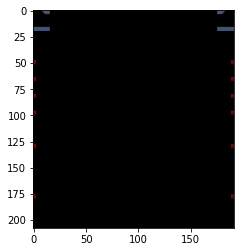

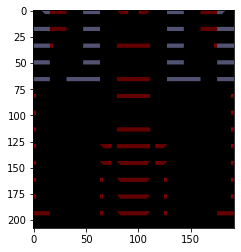

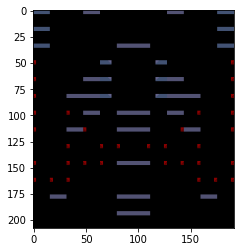

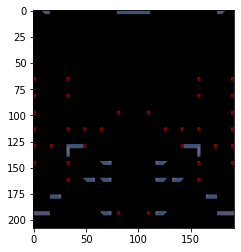

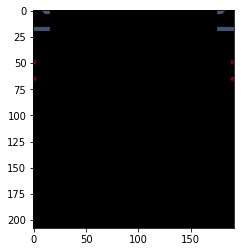

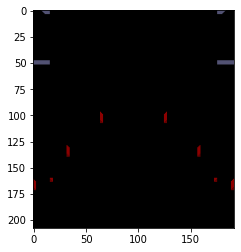

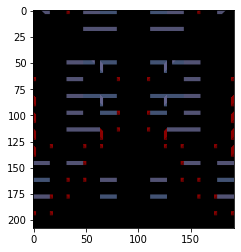

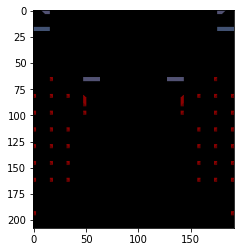

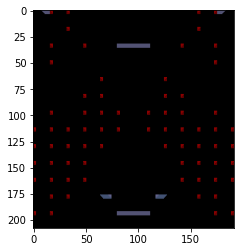

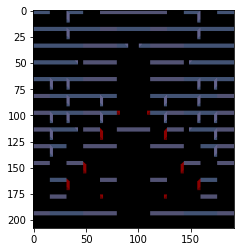

In [186]:
# number of levels to be generated
n_levels=10
for i_ptr in range(n_levels):
    
    N=78
    next_N=78

    embed_path=embedding_paths[i_ptr]
    level_identifier=embed_path.split("/")[-1].split('.')[0]
    level_embedding=get_pickle(embed_path)
    level_column=level_col

    inf_column_batch=[]
    inf_input_batch=[]
    inf_target_batch=[]

    for idx in range(len(level_embedding)-next_N):
        if idx>N:
            print("low bound hit")
            low_bound=idx-N
            data_i=level_embedding[low_bound:idx]
            data_t=level_embedding[idx:idx+next_N]
            data_c=level_column[low_bound:idx]

            assert data_i.shape==(N,256)
            assert data_t.shape==(next_N,256)
        else:
            pad_length=N-idx
            pad_array=np.zeros((pad_length,256))
            data_i=np.concatenate((pad_array,level_embedding[:idx]),axis=0)
            data_t=level_embedding[idx:idx+next_N]

            pad_array1=np.zeros((pad_length,))
            data_c=np.concatenate((pad_array1,level_column[:idx]),axis=0)
            assert data_i.shape==(N,256)
            assert data_t.shape==(next_N,256)
        inf_column_batch.append(data_c)
        inf_input_batch.append(data_i)
        inf_target_batch.append(data_t)

    inf_column_batch=np.array(inf_column_batch)      
    inf_column_batch=inf_column_batch.astype(int)
    inf_input_batch=np.array(inf_input_batch)
    print(f"inf input batch shape: {inf_input_batch.shape}")
    inf_target_batch=np.array(inf_target_batch)

    # initialising annoy
    vec_list=list(idx2embed_map.values())
    print(len(vec_list))
    f = 256
    t = AnnoyIndex(f, 'euclidean')
    for i in range(len(vec_list)):
        t.add_item(i,vec_list[i])
    t.build(15)
    
    generated_level=[]

    tile_count=0
    col_idx=0
    n=2

    col_hist=inf_input_batch[0]
    col=inf_column_batch[0]

    start_input=inf_target_batch[0]
    start_input=start_input[:next_N]

    column_one_hot=np.zeros((1,N,256))
    for i, d in enumerate(col):
        column_one_hot[0,i,d]=1
    col_hist_in=col_hist.reshape(1,N,256)

    start_input_in=start_input.reshape(1,next_N,256)

    o1,h1,c1=hist_model.predict(col_hist_in)
    o2,h2,c2=col_model.predict(column_one_hot)

    oh=Add()([h1,h2])
    oc=Add()([c1,c2])
    
    next_col=inf_model2.predict([start_input_in,oh,oc])
    
    second_half=next_col[0]
    
    assert second_half.shape==(78,256)
    level_embed=roll_embedding(13,6,second_half)
    second_v=visualise_level(level_embed)
    first_v=ImageOps.mirror(second_v)
    
    images = [second_v,first_v]
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    #save_img("../outputs/Bubble_Bobble/level_"+str(i_ptr)+".png",new_im)

    import matplotlib.pyplot as plt
    plt.figure()
    plt.imshow(new_im)

tileMap shape: (14820, 16, 16, 3)
embedMap shape: (14820, 256)
Maps Loaded
Initialised Tree
Building Tree
Tree Built
Annoy Map Trained
Running Model
Running Model
Running Model
Running Model
Running Model
Running Model
Running Model
Running Model
Running Model
Running Model


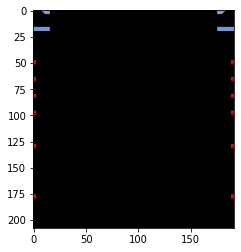

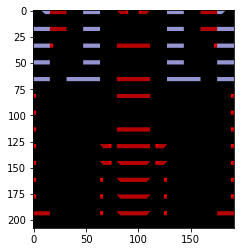

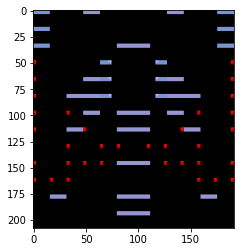

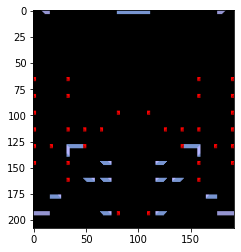

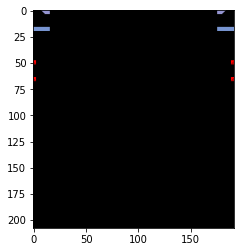

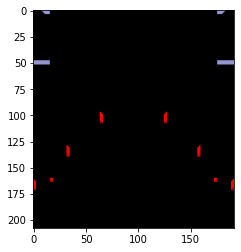

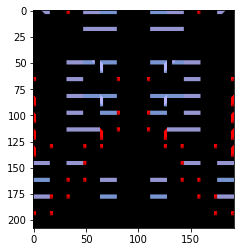

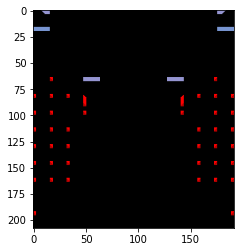

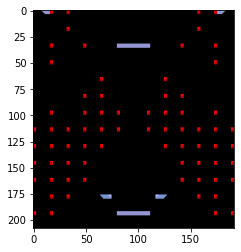

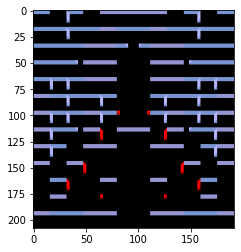

In [223]:
# tileMap = np.load("testrep/BubbleBobble/centerTiles.npy")
# embedMap = np.load("testrep/BubbleBobble/embeddings.npy")

tileMap = np.array(list(get_pickle("../data/unified_rep/bubble_bobble/"+"mappings/idx2tile.pickle").values()))
embedMap = np.array(list(get_pickle("../data/unified_rep/bubble_bobble/"+"mappings/idx2embed.pickle").values()))

print(f"tileMap shape: {tileMap.shape}")
print(f"embedMap shape: {embedMap.shape}")

print("Maps Loaded")

nnTree = AnnoyIndex(256, 'euclidean')

print("Initialised Tree")

#for i in range(embedMap.shape[0]): print(f"Added {i}th item to tree"), nnTree.add_item(i, embedMap[i])
for i in range(embedMap.shape[0]): nnTree.add_item(i, embedMap[i])

print("Building Tree")
nnTree.build(15)
print("Tree Built")

print("Annoy Map Trained")

N = 78
NLevels = 10

for level in range(NLevels):

    levelEmbeddingPath = embedding_paths[level]

    input = []
    column = []
    target = []

    #levelEmbeddingArray = np.load(levelEmbeddingPath)
    levelEmbeddingArray = get_pickle(levelEmbeddingPath)

    for j in range(len(levelEmbeddingArray) - N):

        padLength = N - j

        dataI = np.concatenate((np.zeros(shape=(padLength, 256)), levelEmbeddingArray[:j]), axis=0)

        dataT = levelEmbeddingArray[j:j+N]

        levelIdx = np.concatenate((np.zeros(shape=(padLength)), level_column[:j]), axis=0)
        dataC = np.zeros(shape=(N, 256))
        for j in range(N): dataC[j][int(levelIdx[j])] = 1

        column.append(dataC)
        input.append(dataI)
        target.append(dataT)

    print("Running Model")

    input = np.array(input)
    target = np.array(target)
    column = np.array(column)

    o1, h1, c1 = hist_model.predict(input[0].reshape(1, 78, 256))
    o2, h2, c2 = col_model.predict(column[0].reshape(1, 78, 256))

    oh=Add()([h1,h2])
    oc=Add()([c1,c2])
    
    nextCol = inf_model2.predict([target[0].reshape(1, 78, 256),oh,oc])

    nextCol = np.array(nextCol)
    nextColT = nextCol[:, :78].reshape(6, 13, nextCol.shape[2]).transpose(1, 0, 2)

    levelImage = np.zeros(shape=(nextColT.shape[0] * 16, nextColT.shape[1] * 16, 3), dtype=np.uint8)

    for t, row in enumerate(nextColT):
        for j, embedding in enumerate(row):

            nearestEmbedding = nnTree.get_nns_by_vector(embedding, 2, search_k=-1, include_distances=False)[0]
            tileImage = tileMap[nearestEmbedding]

            levelImage[t*16 : t*16+16, j*16 : j*16+16, :] = tileImage

    levelImage = np.concatenate([levelImage, np.fliplr(levelImage)], axis=1).astype(np.float32)
    levelImage = (levelImage * (255 / levelImage.max())).astype(np.uint8)

    import matplotlib.pyplot as plt

    plt.figure()
    plt.imshow(levelImage)

In [139]:
a = start_input_in
b = target[0].reshape(1, 78, 256)

(a == b).all()

True

In [140]:
a = col_hist_in
b = input[0].reshape(1, 78, 256)

(a == b).all()

True

In [141]:
a = column_one_hot
b = column[0].reshape(1, 78, 256)

(a == b).all()

True

In [149]:
a = next_col
b = nextCol.reshape(1, 78, 256)

print(a.shape)
print(b.shape)

(a == b).all()

(1, 78, 256)
(1, 78, 256)


True

In [150]:
a = level_embed
b = nextColT

print(a.shape)
print(b.shape)

(a == b).all()

(13, 6, 256)
(13, 6, 256)


True

True

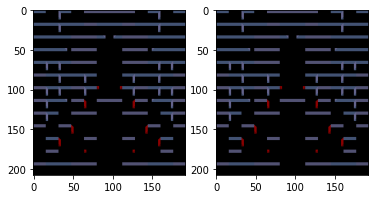

In [197]:
a = np.array(new_im)
b = levelImage

fig, subplots = plt.subplots(1, 2)
subplots[0].imshow(a)
subplots[1].imshow(b)

(a == b).all()

True

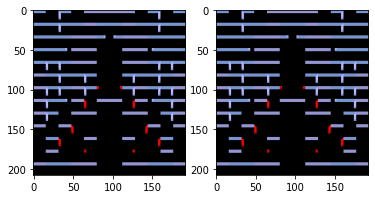

In [198]:
t = np.array(new_im)
y = levelImage

t = np.array(array_to_img(new_im))
y = np.array(array_to_img(levelImage))

fig, subplots = plt.subplots(1, 2)
subplots[0].imshow(t)
subplots[1].imshow(y)

(t == y).all()

In [209]:
print(a.min())
print(a.max())
print(a.mean())
print(a[0][0])
print(t.min())
print(t.max())
print(t.mean())
print(t[0][0])

print("")

print(b.min())
print(b.max())
print(b.mean())
print(b[0][0])
print(y.min())
print(y.max())
print(y.mean())
print(y[0][0])

0
140
17.376001602564102
[ 66  82 115]
0
255
31.58263221153846
[120 149 209]

0
140
17.376001602564102
[ 66  82 115]
0
255
31.58263221153846
[120 149 209]


In [215]:
l = 255 / 140
int(l * 115)

209

In [211]:
140 * (255 / 140)

255.0

True

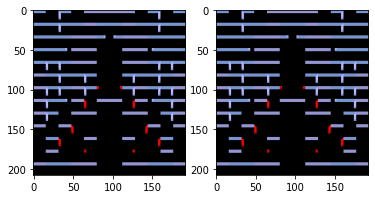

In [217]:
t = np.array(new_im)
y = levelImage

t = np.array(array_to_img(new_im))
y = y.astype(np.float32)
y *= (255 / levelImage.max())
y = y.astype(np.uint8)

fig, subplots = plt.subplots(1, 2)
subplots[0].imshow(t)
subplots[1].imshow(y)

(t == y).all()